# Graph Classification - Mol-HIV
## Experiment results

In [ ]:
import comet_ml
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

sns.set_style('white')

In [ ]:
models = ['gcn', 'sage', 'gin']
types = ['base', 'transfer', 'self-transfer']

***
### Gathering results
Run the cell below to gather all the experiment results from  Comet.ml.

In [ ]:
comet_api = comet_ml.api.API()
experiments = comet_api.get('graph-net-experiments/graph-classification')

# gets dict with experiment_id : set of tags
experiments_with_tags = {
    exp.id: frozenset(exp.get_tags())
    for exp in experiments
}

tags = set(experiments_with_tags.values()) # gets unique tags
experiments_by_tags = { tag: [] for tag in tags } 

# experiments_by_tags: dict with all experiment ids under unique tags
for exp, exp_tags in experiments_with_tags.items():
    experiments_by_tags[exp_tags].append(exp)

experiment_results = { tag: '💩' for tag in tags }  # 💩 emoji will be replaced with exp. results

print('Gathering experiment results')
print('----------------------------')

for exp_model in models:
    print(exp_model + '...')

    for exp_type in types:
        print('    ' + exp_type)
        exp_tag = frozenset({exp_model, exp_type})

        losses = []
        accuracies = []

        for exp_id in experiments_by_tags[exp_tag]:
            loss = np.array([  float(step['metricValue'])
                            for step in comet_api.get_experiment_by_id(exp_id).get_metrics('train_loss')])
            acc   = np.array([  float(step['metricValue']) 
                            for step in comet_api.get_experiment_by_id(exp_id).get_metrics('train_roc-auc')])
            
            # insert nan at end when short of one value
            if len(loss) == 1999: 
                loss = np.hstack( (loss, np.nan) )
            if len(acc) == 1999: 
                acc = np.hstack( (acc, np.nan) )

            losses.append(loss)
            accuracies.append(acc)
            
        losses = np.stack(losses)
        accuracies = np.stack(accuracies)

        experiment_results[exp_tag] = {
            'losses': losses,
            'rocauc': accuracies
        }

Gathering experiment results
----------------------------
gcn...
    base
    transfer
    self-transfer
sage...
    base
    transfer
    self-transfer
gin...
    base
    transfer
    self-transfer


In [ ]:
torch.save(experiment_results, 'experiment_result_dict')

### Plotting results
Alternatively, use saved results from `experiment_result_dict`.

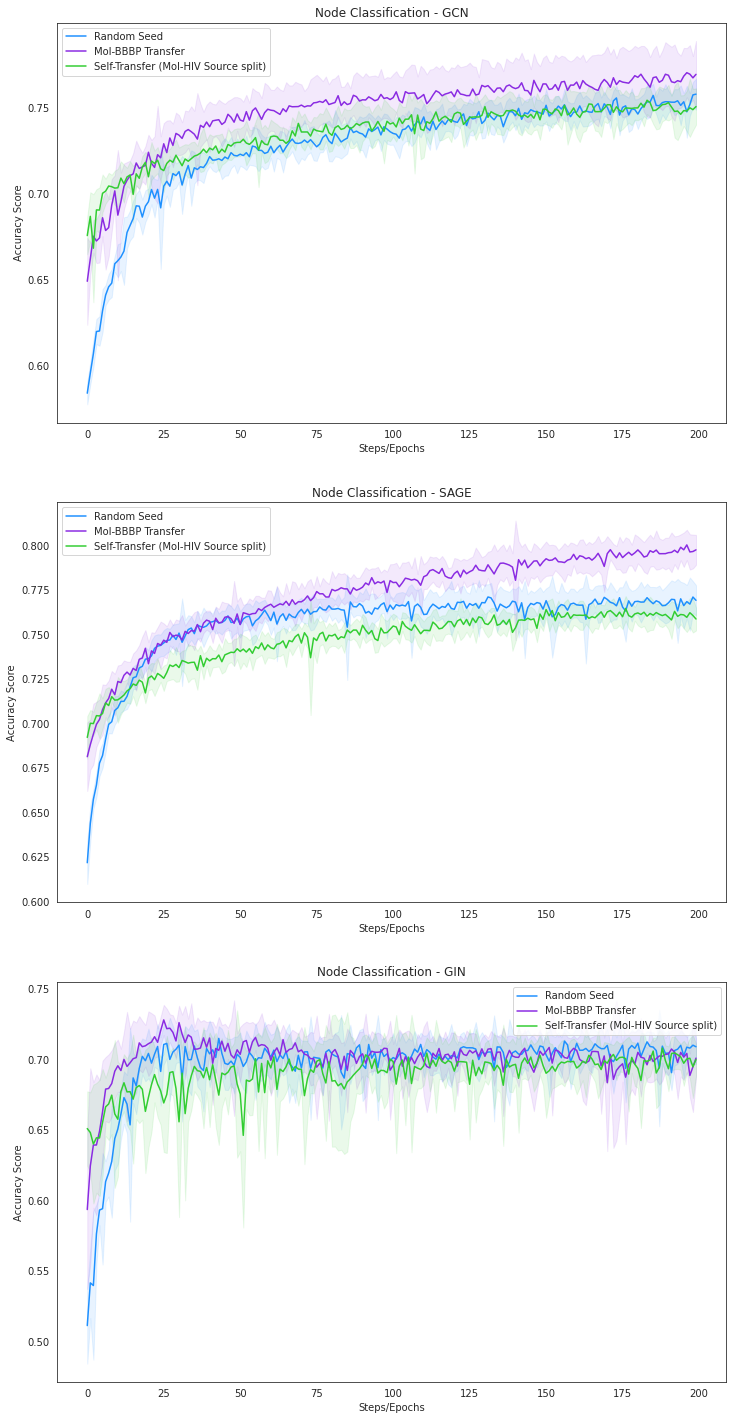

In [ ]:
experiment_results = torch.load('experiment_result_dict')
legend_dict = {'base': 'Random Seed', 'transfer': 'Mol-BBBP Transfer', 'self-transfer': 'Self-Transfer (Mol-HIV Source split)'}
colours = {'base': 'dodgerblue', 'transfer': 'blueviolet', 'self-transfer': 'limegreen'}

plt.figure(figsize=(12, 25))

for i, model in enumerate(models):
    plt.subplot(3,1,i+1)

    for type_ in types:
        acc = experiment_results[frozenset({model, type_})]['rocauc']
        acc_mean = acc.mean(axis=0)
        acc_std = (acc_mean + acc.std(axis=0), acc_mean - acc.std(axis=0))

        plt.plot(acc.mean(axis=0), label=legend_dict[type_], color=colours[type_])
        plt.fill_between(np.arange(len(acc_mean)), acc_std[0], acc_std[1], alpha=0.1, color=colours[type_])
    
    plt.xlabel('Steps/Epochs')
    plt.ylabel('Accuracy Score')
    plt.title('Node Classification - ' + model.upper())
    plt.legend()